Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 
Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.
Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

Описание данных
Данные находятся в файле /datasets/Churn.csv (англ. «отток клиентов»). Скачать датасет
Признаки
RowNumber — индекс строки в данных
CustomerId — уникальный идентификатор клиента
Surname — фамилия
CreditScore — кредитный рейтинг
Geography — страна проживания
Gender — пол
Age — возраст
Tenure — сколько лет человек является клиентом банка
Balance — баланс на счёте
NumOfProducts — количество продуктов банка, используемых клиентом
HasCrCard — наличие кредитной карты
IsActiveMember — активность клиента
EstimatedSalary — предполагаемая зарплата
Целевой признак
Exited — факт ухода клиента

Загрузите и подготовьте данные. Поясните порядок действий.
Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.
Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.
Проведите финальное тестирование.

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve,\
                            confusion_matrix, mean_absolute_error
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [20]:
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    df = pd.read_csv('Churn.csv') 

In [13]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [14]:
df.shape

(10000, 14)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


**Названия столбцов:**
 - RowNumber — индекс строки в данных
 - CustomerId — уникальный идентификатор клиента
 - Surname — фамилия
 - CreditScore — кредитный рейтинг
 - Geography — страна проживания
 - Gender — пол
 - Age — возраст
 - Tenure — сколько лет человек является клиентом банка
 - Balance — баланс на счёте
 - NumOfProducts — количество продуктов банка, используемых клиентом
 - HasCrCard — наличие кредитной карты
 - IsActiveMember — активность клиента
 - EstimatedSalary — предполагаемая зарплата
 - Exited — факт ухода клиента

In [16]:
#Теперь посмотрим на пропуски,используя  градиент:
pd.DataFrame(round(df.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
RowNumber,0.000000
CustomerId,0.000000
Surname,0.000000
CreditScore,0.000000
Geography,0.000000
Gender,0.000000
Age,0.000000
Tenure,0.000000
Balance,0.000000
NumOfProducts,0.000000


In [25]:
#correctness of column names
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [26]:
print(f'Count duplicated: {df.duplicated().sum()}')

Count duplicated: 0


### Исследование задачи

In [28]:
#Удалим из дальнейшей работы столбцы с индексом строки, id клиента и фамилиями,
#для построения моделей машинного обучения они нам не потребуются 
df = df.drop(['RowNumber', 'CustomerId', 'Surname'] , axis=1)

In [33]:
df.Geography.nunique()

3

<AxesSubplot:>

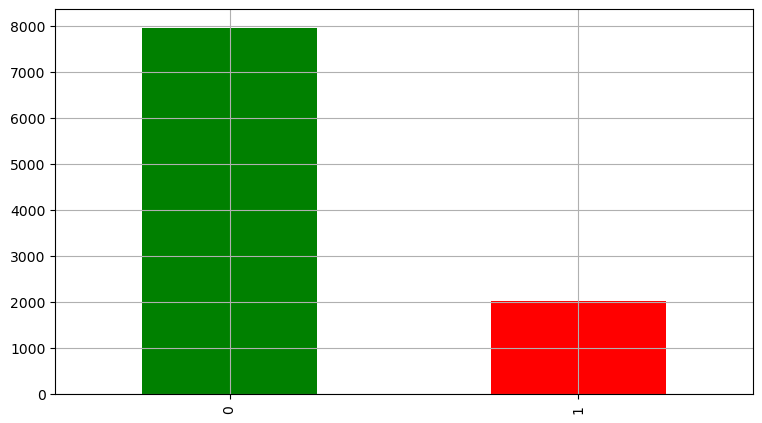

In [38]:
# Exited — факт ухода клиента,посмотрим графически на распределение данных в колонке
df.Exited.value_counts().plot(kind='bar',figsize=(9,5),color=['g','r'],grid=True)

<AxesSubplot:>

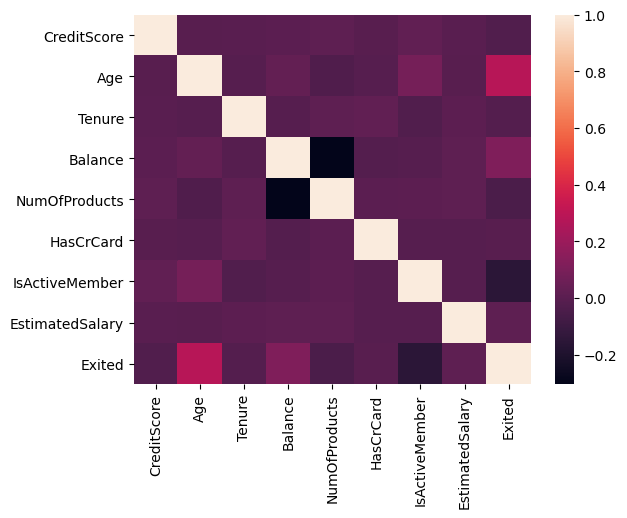

In [42]:
#корреляция целевого показателя в разрезе признаков
sns.heatmap(df.corr())
